### Background
- Необходимость сократить время на осуществление относительно простых, но в тоже время рутинных и часто возникающих CFD-расчетов трубопроводов различного назначения

### Purpose
- Оценить состоятельность и эффективность применения Deep Convolutional Neural Networks для решения поставленной задачи, а также общие трудо- и время- затраты (на обучение модели и т.д.)
- Применить полученные на курсе знания и навыки для решения практической (насущной) задачи
- Получить новый опыт

---
- `FinalProject_ModelListGeneration.py` - скрипт генерации параметров геометрии CFD моделей
- `FinalProject_CadModelGeneration.ipynb` - скрипт генерации CAD моделей по параметрам
- `FinalProject_CfdModelGeneration.FCMacro` - скрипт генерации CFD моделей из CAD
- `runALLAllmesh`, `runALLAllrun` - скрипты запуска генерации расчетной сетки и запуска CFD расчета
- `FinalProject_GettingResults_v1.py` - скрипт извлечения результатов



- [DATA EXAMPLES](https://drive.google.com/drive/folders/1BUo5T81UsoqGpVlbbAevScY0er5NXZrp?usp=sharing)

---

In [1]:
# libraries importing
import os, glob, itertools, re, pickle, json, random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from tqdm import tqdm, trange

from PIL import Image
import cv2

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from FinalProject_ModelListGeneration import get_models_list

In [2]:
# environment setting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
DATA_PATH = 'D:\\DataScience\\FinalProject\\cfd_results\\10mm'

## Data importing

### Tabular data

In [ ]:
# # getting list with models parameters
# models = get_models_list()

# models = models[models['diameter']==10]
# models.reset_index(drop=True, inplace=True)
# models.drop(columns=['diameter'], inplace=True)

# display(models.head(3), models.shape)

In [ ]:
# # getting cfd-analysis tabular results data
# tables_list = glob.glob(os.path.join(DATA_PATH, '*', '*.csv'))

# for i, table in enumerate(tables_list):
#     if i == 0:
#         results = pd.read_csv(table)
#     else:
#         results = results.append(pd.read_csv(table), ignore_index=True)

# display(results.head(3), results.shape)

In [ ]:
# # concatenate data (parameters + cfd-results)
# models = models.merge(results, how='right', on='description')

# display(models.head(3), models.shape)

#### Preprocessing

- Для обучения нейросети будем использовать отдельно каждую "секцию" по отдельности со своими распределениями скоростей и давления на входном и выходном сечениях. Так же "дадим модели знать" о параметрах предыдущей и последующей секциях.

In [ ]:
# # list of necessary data for learning
# data = {'before_size':[],
#         'before_shape':[],
#         'before_direction':[],
#         'current_size':[],
#         'current_shape':[],
#         'current_direction':[],
#         'after_size':[],
#         'after_shape':[],
#         'after_direction':[],
#         'inlet-P_min':[],
#         'inlet-P_max':[],
#         'inlet-UX_min':[],
#         'inlet-UX_max':[],
#         'inlet-UY_min':[],
#         'inlet-UY_max':[],
#         'inlet-UZ_min':[],
#         'inlet-UZ_max':[],
#         'outlet-P_min':[],
#         'outlet-P_max':[],
#         'outlet-UX_min':[],
#         'outlet-UX_max':[],
#         'outlet-UY_min':[],
#         'outlet-UY_max':[],
#         'outlet-UZ_min':[],
#         'outlet-UZ_max':[]
#        }

In [ ]:
# # getting each section of model as one data row
# for i in range(len(models)):
    
#     section_count = int((len(models['description'][i].split('-'))-1)/3)
    
#     '''
#     Getting parameters of current section and also previous and next sections.
#     If section is first or last set 0 for the all parameters of
#     previous or next section respectively.
#     '''
#     for j in range(section_count):
#         for x in range(0,7,3):
#             for y,column in enumerate(list(data.keys())[x:x+3]):
#                 if x == 3:
#                     data[column].append(models.iloc[i, j+3*y])
#                 elif x == 0:
#                     if j == section_count-1 or j == 0:
#                         data[column].append(0)
#                     else:
#                         data[column].append(models.iloc[i, j-1+3*y])
#                 else:
#                     if j == section_count-1:
#                         data[column].append(0)
#                     else:
#                         data[column].append(models.iloc[i, j+1+3*y])
        
#         '''
#         Getting results of section INLET and OUTLET
#         '''
#         inlet_idx = 's'+str(j)
#         outlet_idx = 's'+str(j+1)
        
#         d = {'inlet':inlet_idx,
#              'outlet':outlet_idx}
        
#         cnt = 0
        
#         for column in list(data.keys())[9:25]:
#             cnt += 1
#             result = column.split('-')
#             data[column].append(models[d[result[0]]+'-'+result[1]][i])
            
#             ## getting path to images 
#             if cnt % 2 == 0:
#                 result[1] = result[1].split('_')[0]
                
#                 new_column = result[0]+'-'+result[1]+'_image'
#                 img_name = d[result[0]]+'-'+result[1]+'.png'
#                 path2img = glob.glob(os.path.join(DATA_PATH, '*', models['description'][i], img_name))[0]
                
#                 if new_column not in list(data.keys()):
#                     data[new_column] = []
#                 data[new_column].append(path2img)

In [ ]:
# df = pd.DataFrame(data)

# display(df.head(3), df.shape)

In [ ]:
# df.info()

In [ ]:
# # Lable encoding
# encoder = LabelEncoder()

# for column in list(df.columns)[:-int(cnt/2)]:
#     if df[column].dtypes == 'O':
#         df[column] = df[column].apply(str)
#         df[column] = encoder.fit_transform(df[column])

# display(df.head(3), df.shape)

- Дабы при каждом перезапуске не проводить преобразование выше, сохраним датафрейм и далее будем подгружат данные из него

In [ ]:
# df.to_csv(os.path.join('D:/DataScience/FinalProject', 'data.csv'), index=False)

In [ ]:
df = pd.read_csv(os.path.join('D:/DataScience/FinalProject', 'data.csv'))
display(df.head(3), df.shape)

In [ ]:
df.info()

In [ ]:
rslt = list(df.columns)[9:-8]

n_rslt = len(rslt)

fig, axs = plt.subplots(int(n_rslt/2), 2, figsize=(20, n_rslt*3))

for i, j in enumerate(rslt):
    min_value=round(df[j].min(), 1)
    max_value=round(df[j].max(), 1)

    axs[i//2][i%2].hist(df[j], bins='auto')
    axs[i//2][i%2].set_title(f'{j}: Min.val.={min_value}, Max.val.={max_value}')
    axs[i//2][i%2].grid(True, axis='y', alpha=0.5)
    axs[i//2][i%2].set_ylabel('Count')

### Image data

In [ ]:
def get_img_samples(n_smpl=5, df=df, s_sart=-8, s_end=None):

    plt.figure(figsize=(20, n_smpl*2))

    for i, (x, y) in enumerate(itertools.product(df.sample(n_smpl).index, list(df.columns)[s_sart:s_end])):
        file_name = df[y][x]
        img = Image.open(file_name)
        plt.subplot(n_smpl, 8, i+1)
        plt.imshow(img)
        plt.title(f"{x}-{y}")
        plt.axis('off')

    plt.show()

In [ ]:
get_img_samples()

#### Preprocessing

In [ ]:
img_path = df['inlet-P_image'][2924]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# plt.figure(figsize=(20,20))
plt.imshow(img, cmap='gray')
plt.colorbar()

In [ ]:
np.unique(img)

In [ ]:
print(f"Max.val.= {df['inlet-P_max'][2924]},\nMin.val.= {df['inlet-P_min'][2924]}")

In [ ]:
def get_preprocessed_image(column, row, ratio=4, df=df, save=False, data_path=DATA_PATH):
    
    '''loading image'''
    img_path = df[column][row]
    # as single channel image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # downsizing
    img_h, img_w = img.shape
    assert img_h % ratio == 0 and img_w % ratio == 0, 'Image size must be even divisible by resizing ratio'
    new_size = (img_w//ratio, img_h//ratio)
    img_changed = cv2.resize(img, new_size, interpolation=cv2.INTER_NEAREST)
    
    # normalize pixels value (optional)
    img_changed = img_changed/255

    '''scaling'''
    img_h, img_w = img_changed.shape
    # values range
    max_val = df[column.replace('image', 'max')][row]
    min_val = df[column.replace('image', 'min')][row]
    # pixels value range
    max_val_px = np.unique(img_changed)[-1]
    min_val_px = np.unique(img_changed)[1]

    '''set real value as pixel grey value'''
    for h, w in list(itertools.product(range(img_h), range(img_w))):
        '''
        If a pixel has a value of 0, it means that it is outside the pipe cross section
        Set it to the value of atmospheric pressure, in the case of CFD analysis equal to 0.
        '''
        if img_changed.item(h, w) != 0:
            real_val = (img_changed.item(h, w)-min_val_px)\
                        * (max_val-min_val)/(max_val_px-min_val_px) + min_val
        else:
            real_val = 0

        img_changed.itemset((h, w), real_val / 127.5)

    '''saving preprocessed image, if required'''
    if save:
        found_names = re.findall(r"\d+.+?[^\\]*", img_path)
        batch_name = found_names[1]
        model_name = found_names[2]
        img_name = os.path.basename(img_path)

        save_path = os.path.join(data_path.replace('cfd_results', 'img_preprocessing'),
                                 batch_name,
                                 model_name)
        os.makedirs(save_path, exist_ok=True)
        '''
        The adding 127.5 to each pixel shifts the zero to a mid-grey value,
        shows negative values as darker, and positive values as lighter.
        '''
        cv2.imwrite(os.path.join(save_path, img_name), img_changed + 127.5)

    return np.array(img_changed.astype('float32')), img_h, img_w

---
##### Checking function work

In [ ]:
img_changed, _, _ = get_preprocessed_image(column='inlet-P_image',
                                           row=2924)

# plt.figure(figsize=(20,20))
plt.imshow(img_changed, cmap='gray')
plt.colorbar()

In [ ]:
np.unique(img_changed)

---

In [ ]:
def get_geom_channel(row, df=df, img_h=512, img_w=512):
    
    h = img_h//3 + 1
    w = img_w//3 + 1
    
    '''create filled with zeros array'''
    s = (img_h, img_w)
    geom_param = np.zeros(s)
    
    '''fill by previous geom'''
    geom_param[:] = df[list(df.columns)[0]][row]
    geom_param[:,w:] = df[list(df.columns)[1]][row]
    geom_param[:,-w:] = df[list(df.columns)[2]][row]
    
    '''fill by current geom'''
    geom_param[h:] = df[list(df.columns)[3]][row]
    geom_param[h:,w:] = df[list(df.columns)[4]][row]
    geom_param[h:,-w:] = df[list(df.columns)[5]][row]
    
    '''fill by next geom'''
    geom_param[-h:] = df[list(df.columns)[6]][row]
    geom_param[-h:,w:] = df[list(df.columns)[7]][row]
    geom_param[-h:,-w:] = df[list(df.columns)[8]][row]
    
    return geom_param.astype('float32')

---
##### Checking function work

In [ ]:
geom_param = get_geom_channel(2924)

# plt.figure(figsize=(20,20))
plt.imshow(geom_param, cmap='gray')
plt.colorbar()

In [ ]:
np.unique(geom_param)

---
## Dataset preparing

In [ ]:
def get_channels_set(column_list, row, df=df, with_geom=True):
    
    channels_set = []
    
    for column in column_list:
        value_channel, img_h, img_w = get_preprocessed_image(column=column,
                                                             row=row,
                                                             df=df)
        channels_set.append(value_channel)
    
    if with_geom:
        geom_channel = get_geom_channel(row=row,
                                        df=df,
                                        img_h=img_h,
                                        img_w=img_w)
        channels_set.append(geom_channel)

    return channels_set

In [ ]:
dataset_lists = {'dataX_model_V':[['inlet-UX_image',
                                   'inlet-UY_image',
                                   'inlet-UZ_image'], True],
                 
                 'dataX_model_P':[['outlet-P_image',
                                   'outlet-UX_image',
                                   'outlet-UY_image',
                                   'outlet-UZ_image'], False],
                 
                 'dataY_model_V':[['outlet-UX_image',
                                   'outlet-UY_image',
                                   'outlet-UZ_image'], False],
                 
                 'dataY_model_P':[['inlet-P_image'], False]}

In [ ]:
for ds in list(dataset_lists.keys()):

    data = Parallel(n_jobs=-1)(delayed(get_channels_set)(column_list=dataset_lists[ds][0],
                                                         with_geom=dataset_lists[ds][1],
                                                         row=row) for row in trange(len(df)))
    f = open(ds + '.pkl', 'wb')
    pickle.dump(data, f)
    f.close()
    del data

---
##### Checking function work

In [ ]:
x = pickle.load(open("dataX_model_V.pkl", "rb"))

plt.figure(figsize=(20,4))

for i in range(len(x[0])):
    plt.subplot(1, len(x[0]), i+1)
    plt.imshow(x[2924][i], cmap='gray')
    plt.colorbar()

# DeepCFD

In [4]:
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm

import copy

In [5]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2060 with Max-Q Design (UUID: GPU-05df1c92-ad9b-711e-a79e-eaa2ef54918a)


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(RANDOM_SEED)

### Helper functions

In [7]:
def split_tensors(*tensors, ratio):
    assert len(tensors) > 0
    split1, split2 = [], []
    count = len(tensors[0])
    for tensor in tensors:
        assert len(tensor) == count
        split1.append(tensor[:int(len(tensor) * ratio)])
        split2.append(tensor[int(len(tensor) * ratio):])
    if len(tensors) == 1:
        split1, split2 = split1[0], split2[0]
    return split1, split2

In [8]:
def create_layer(in_channels,
                 out_channels,
                 kernel_size,
                 wn=True,
                 bn=True,
                 activation=nn.ReLU,
                 convolution=nn.Conv2d):

    assert kernel_size % 2 == 1
    layer = []
    conv = convolution(in_channels,
                       out_channels,
                       kernel_size,
                       padding=kernel_size//2)
    if wn:
        conv = weight_norm(conv)
    
    layer.append(conv)
    
    if activation is not None:
        layer.append(activation())
    
    if bn:
        layer.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layer)

In [9]:
def create_encoder_block(in_channels,
                         out_channels,
                         kernel_size,
                         wn=True,
                         bn=True,
                         activation=nn.ReLU,
                         layers=2):
    
    encoder = []
    for i in range(layers):
        _in = out_channels
        _out = out_channels
        if i == 0:
            _in = in_channels
        encoder.append(create_layer(_in, _out, kernel_size, wn, bn, activation, nn.Conv2d))
    return nn.Sequential(*encoder)

In [10]:
def create_decoder_block(in_channels,
                         out_channels,
                         kernel_size,
                         wn=True,
                         bn=True,
                         activation=nn.ReLU,
                         layers=2,
                         final_layer=False):
    
    decoder = []
    for i in range(layers):
        _in = in_channels
        _out = in_channels
        _bn = bn
        _activation = activation
        if i == 0:
            _in = in_channels * 2
        if i == layers - 1:
            _out = out_channels
            if final_layer:
                _bn = False
                _activation = None
        decoder.append(create_layer(_in, _out, kernel_size, wn, _bn, _activation, nn.ConvTranspose2d))
    return nn.Sequential(*decoder)

In [11]:
def create_encoder(in_channels,
                   filters,
                   kernel_size,
                   wn=True,
                   bn=True,
                   activation=nn.ReLU,
                   layers=2):
    
    encoder = []
    for i in range(len(filters)):
        if i == 0:
            encoder_layer = create_encoder_block(in_channels,
                                                 filters[i],
                                                 kernel_size,
                                                 wn,
                                                 bn,
                                                 activation,
                                                 layers)
        else:
            encoder_layer = create_encoder_block(filters[i-1],
                                                 filters[i],
                                                 kernel_size,
                                                 wn,
                                                 bn,
                                                 activation,
                                                 layers)
        encoder = encoder + [encoder_layer]
    return nn.Sequential(*encoder)

In [12]:
def create_decoder(out_channels,
                   filters,
                   kernel_size,
                   wn=True,
                   bn=True,
                   activation=nn.ReLU,
                   layers=2):
    
    decoder = []
    for i in range(len(filters)):
        if i == 0:
            decoder_layer = create_decoder_block(filters[i],
                                                 out_channels,
                                                 kernel_size,
                                                 wn,
                                                 bn,
                                                 activation,
                                                 layers,
                                                 final_layer=True)
        else:
            decoder_layer = create_decoder_block(filters[i],
                                                 filters[i-1],
                                                 kernel_size,
                                                 wn,
                                                 bn,
                                                 activation,
                                                 layers,
                                                 final_layer=False)
        decoder = [decoder_layer] + decoder
    return nn.Sequential(*decoder)

In [13]:
def initialize(model, gain=1, std=0.02):
    for module in model.modules():
        if type(module) in [nn.Linear, nn.Conv1d, nn.Conv2d, nn.Conv3d]:
            nn.init.xavier_normal_(module.weight, gain)
            if module.bias is not None:
                nn.init.normal_(module.bias, 0, std)

In [14]:
def visualize(sample_y, out_y, error):
    
    var_list = [sample_y, out_y, error]
    title_list = ['CFD', 'CNN', 'Error']
    lable_list = ['Ux', 'Uy', 'Uz']

    output_size = len(out_y) #10
    output_channels = len(out_y[0]) #3

    smpl = random.randint(0, output_size-1)

    plt.figure(figsize=(20, output_channels*5))
    
    cnt = 0

    for i in range(output_channels):

        vmin_sample = np.min(sample_y[smpl, i, :, :])
        vmax_sample = np.max(sample_y[smpl, i, :, :])

        vmin_out = np.min(out_y[smpl, i, :, :])
        vmax_out = np.max(out_y[smpl, i, :, :])
        
        vmin_error = np.min(error[smpl, i, :, :])
        vmax_error = np.max(error[smpl, i, :, :])

        for j in range(3):
            
            cnt += 1

            plt.subplot(output_channels, 3, cnt)
            
            if j == 0:
                if output_channels > 1:
                    plt.ylabel(f'{lable_list[i]}', fontsize=18)
                else:
                    plt.ylabel('P', fontsize=18)
            
            if j != 2:
                vmin = min(vmin_sample, vmin_out)
                vmax = max(vmax_sample, vmax_out)
            else:
                vmin = vmin_error
                vmax = vmax_error
            
            plt.imshow(np.transpose(var_list[j][smpl, i, :, :]),
                       vmin = vmin,
                       vmax = vmax)
            
            plt.colorbar()#.ax.tick_params(labelsize=18)
            
            if i == 0:
                plt.title(f'{title_list[j]}', fontsize=18)
    
    plt.show()

In [15]:
def generate_metrics_list(metrics_def):
    list = {}
    for name in metrics_def.keys():
        list[name] = []
    return list

In [16]:
def epoch(scope, loader, on_batch=None, training=False):
    model = scope["model"]
    optimizer = scope["optimizer"]
    loss_func = scope["loss_func"]
    metrics_def = scope["metrics_def"]
    scope = copy.copy(scope)
    scope["loader"] = loader

    metrics_list = generate_metrics_list(metrics_def)
    total_loss = 0
    if training:
        model.train()
    else:
        model.eval()
    for tensors in loader:
        if "process_batch" in scope and scope["process_batch"] is not None:
            tensors = scope["process_batch"](tensors)
        if "device" in scope and scope["device"] is not None:
            tensors = [tensor.to(scope["device"]) for tensor in tensors]
        loss, output = loss_func(model, tensors)
        if training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_loss += loss.item()
        scope["batch"] = tensors
        scope["loss"] = loss
        scope["output"] = output
        scope["batch_metrics"] = {}
        for name, metric in metrics_def.items():
            value = metric["on_batch"](scope)
            scope["batch_metrics"][name] = value
            metrics_list[name].append(value)
        if on_batch is not None:
            on_batch(scope)
    scope["metrics_list"] = metrics_list
    metrics = {}
    for name in metrics_def.keys():
        scope["list"] = scope["metrics_list"][name]
        metrics[name] = metrics_def[name]["on_epoch"](scope)
    return total_loss, metrics

In [17]:
def train(scope,
          train_dataset,
          val_dataset,
          patience=10,
          batch_size=256,
          print_function=print,
          eval_model=None,
          on_train_batch=None,
          on_val_batch=None,
          on_train_epoch=None,
          on_val_epoch=None,
          after_epoch=None):
    
    epochs = scope["epochs"]
    model = scope["model"]
    metrics_def = scope["metrics_def"]
    scope = copy.copy(scope)

    scope["best_train_metric"] = None
    scope["best_train_loss"] = float("inf")
    scope["best_val_metrics"] = None
    scope["best_val_loss"] = float("inf")
    scope["best_model"] = None

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    skips = 0
    for epoch_id in range(1, epochs + 1):
        scope["epoch"] = epoch_id
        print_function("Epoch #" + str(epoch_id))
        
        # Training
        scope["dataset"] = train_dataset
        train_loss, train_metrics = epoch(scope, train_loader, on_train_batch, training=True)
        scope["train_loss"] = train_loss
        scope["train_metrics"] = train_metrics
        print_function("\tTrain Loss = " + str(train_loss))
        for name in metrics_def.keys():
            print_function("\tTrain " + metrics_def[name]["name"] + " = " + str(train_metrics[name]))
        if on_train_epoch is not None:
            on_train_epoch(scope)
        del scope["dataset"]
        
        # Validation
        scope["dataset"] = val_dataset
        with torch.no_grad():
            val_loss, val_metrics = epoch(scope, val_loader, on_val_batch, training=False)
        scope["val_loss"] = val_loss
        scope["val_metrics"] = val_metrics
        print_function("\tValidation Loss = " + str(val_loss))
        for name in metrics_def.keys():
            print_function("\tValidation " + metrics_def[name]["name"] + " = " + str(val_metrics[name]))
        if on_val_epoch is not None:
            on_val_epoch(scope)
        del scope["dataset"]
        
        # Selection
        is_best = None
        if eval_model is not None:
            is_best = eval_model(scope)
        if is_best is None:
            is_best = val_loss < scope["best_val_loss"]
        if is_best:
            scope["best_train_metric"] = train_metrics
            scope["best_train_loss"] = train_loss
            scope["best_val_metrics"] = val_metrics
            scope["best_val_loss"] = val_loss
            scope["best_model"] = copy.deepcopy(model)
            print_function("Model saved!")
            skips = 0
        else:
            skips += 1
        if after_epoch is not None:
            after_epoch(scope)

    return scope["best_model"],\
           scope["best_train_metric"],\
           scope["best_train_loss"],\
           scope["best_val_metrics"],\
           scope["best_val_loss"]

In [18]:
def train_model(model,
                loss_func,
                train_dataset,
                val_dataset,
                optimizer,
                process_batch=None,
                eval_model=None,
                on_train_batch=None,
                on_val_batch=None,
                on_train_epoch=None,
                on_val_epoch=None,
                after_epoch=None,
                epochs=100,
                batch_size=256,
                patience=10,
                device=0,
                **kwargs):
    
    model = model.to(device)
    
    scope = {}
    scope["model"] = model
    scope["loss_func"] = loss_func
    scope["train_dataset"] = train_dataset
    scope["val_dataset"] = val_dataset
    scope["optimizer"] = optimizer
    scope["process_batch"] = process_batch
    scope["epochs"] = epochs
    scope["batch_size"] = batch_size
    scope["device"] = device
    metrics_def = {}
    names = []
    
    for key in kwargs.keys():
        parts = key.split("_")
        if len(parts) == 3 and parts[0] == "m":
            if parts[1] not in names:
                names.append(parts[1])
    
    for name in names:
        if "m_" + name + "_name" in kwargs and "m_" + name + "_on_batch" in kwargs and "m_" + name + "_on_epoch" in kwargs:
            metrics_def[name] = {
                "name": kwargs["m_" + name + "_name"],
                "on_batch": kwargs["m_" + name + "_on_batch"],
                "on_epoch": kwargs["m_" + name + "_on_epoch"],
            }
        else:
            print("Warning: " + name + " metric is incomplete!")
    scope["metrics_def"] = metrics_def
    
    return train(scope,
                 train_dataset,
                 val_dataset,
                 eval_model=eval_model,
                 on_train_batch=on_train_batch,
                 on_val_batch=on_val_batch,
                 on_train_epoch=on_train_epoch,
                 on_val_epoch=on_val_epoch,
                 after_epoch=after_epoch,
                 batch_size=batch_size,
                 patience=patience)

In [19]:
class UNetEx(nn.Module):
    
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 filters=[16, 32, 64],
                 layers=3,
                 weight_norm=True,
                 batch_norm=True,
                 activation=nn.ReLU,
                 final_activation=None):
        
        super().__init__()
        assert len(filters) > 0
        self.final_activation = final_activation
        self.encoder = create_encoder(in_channels,
                                      filters,
                                      kernel_size,
                                      weight_norm,
                                      batch_norm,
                                      activation,
                                      layers)
        
        decoders = []
        for i in range(out_channels):
            decoders.append(create_decoder(1,
                                           filters,
                                           kernel_size,
                                           weight_norm,
                                           batch_norm,
                                           activation,
                                           layers))
            
        self.decoders = nn.Sequential(*decoders)

    def encode(self, x):
        tensors = []
        indices = []
        sizes = []
        
        for encoder in self.encoder:
            x = encoder(x)
            sizes.append(x.size())
            tensors.append(x)
            x, ind = F.max_pool2d(x, 2, 2, return_indices=True)
            indices.append(ind)
        
        return x, tensors, indices, sizes

    def decode(self, _x, _tensors, _indices, _sizes):
        
        y = []
        
        for _decoder in self.decoders:
            x = _x
            tensors = _tensors[:]
            indices = _indices[:]
            sizes = _sizes[:]
            for decoder in _decoder:
                tensor = tensors.pop()
                size = sizes.pop()
                ind = indices.pop()
                x = F.max_unpool2d(x, ind, 2, 2, output_size=size)
                x = torch.cat([tensor, x], dim=1)
                x = decoder(x)
            y.append(x)
            
        return torch.cat(y, dim=1)

    def forward(self, x):
        x, tensors, indices, sizes = self.encode(x)
        x = self.decode(x, tensors, indices, sizes)
        if self.final_activation is not None:
            x = self.final_activation(x)
        
        return x

## Model V

##### "Velocity to Velocity"

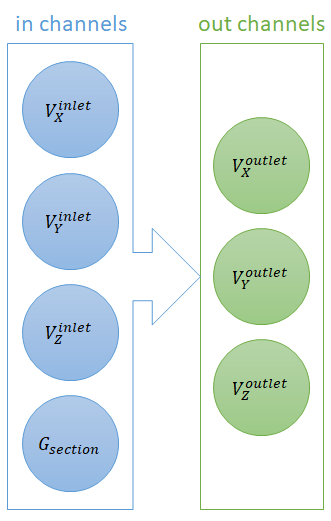

In [20]:
DATA_X_PATH = "D:/DataScience/FinalProject/dataX_model_V.pkl"
DATA_Y_PATH = "D:/DataScience/FinalProject/dataY_model_V.pkl"

# Loading dataset
x = pickle.load(open(DATA_X_PATH, "rb"))
y = pickle.load(open(DATA_Y_PATH, "rb"))

assert len(x) == len(y)

# Shuffling dataset
dataset_size = len(x)
indices = list(range(dataset_size))
np.random.shuffle(indices)
x = np.array(x)[indices]
y = np.array(y)[indices]

In [21]:
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

x_Ns, x_Nc, x_Nx, x_Ny = x.shape
y_Ns, y_Nc, y_Nx, y_Ny = y.shape

if len(y[0]) > 1:
    channels_weights = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1)\
                                         .reshape((y_Ns*y_Nx*y_Ny, y_Nc)) ** 2, dim=0)).view(1, -1, 1, 1).to(device)
    
    print(channels_weights)

tensor([[[[3.6993]],

         [[3.3543]],

         [[6.7460]]]], device='cuda:0')


In [22]:
simulation_directory = "./Run/"
if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)

In [23]:
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)

train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)        
test_x, test_y = test_dataset[:]

In [24]:
# Learning parameters
lr = 0.001
kernel_size = 5
filters = [8, 16, 32, 32]
# filters = [8, 16, 16, 32, 32]
bn = False
wn = False
wd = 0.005
model = UNetEx(x_Nc,
               y_Nc,
               filters=filters,
               kernel_size=kernel_size,
               batch_norm=bn,
               weight_norm=wn)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

BATCH_SIZE = 64
EPOCHS = 1000

In [25]:
config = {}        
train_loss_curve = []
test_loss_curve = []

train_mse_curve = []
test_mse_curve = []

train_ux_curve = []
test_ux_curve = []

train_uy_curve = []
test_uy_curve = []

train_uz_curve = []
test_uz_curve = []

# train_p_curve = []
# test_p_curve = []

def after_epoch(scope):
    train_loss_curve.append(scope["train_loss"])
    test_loss_curve.append(scope["val_loss"])
    
    train_mse_curve.append(scope["train_metrics"]["mse"])
    test_mse_curve.append(scope["val_metrics"]["mse"])
    
    train_ux_curve.append(scope["train_metrics"]["ux"])
    test_ux_curve.append(scope["val_metrics"]["ux"])
    
    train_uy_curve.append(scope["train_metrics"]["uy"])
    test_uy_curve.append(scope["val_metrics"]["uy"])
    
    train_uz_curve.append(scope["train_metrics"]["uz"])
    test_uz_curve.append(scope["val_metrics"]["uz"])
    
#     train_p_curve.append(scope["train_metrics"]["p"])
#     test_p_curve.append(scope["val_metrics"]["p"])

In [26]:
def loss_func(model, batch):
    x, y = batch
    output = model(x)
    
    if len(y[0]) > 1:
        lossu = ((output[:,0,:,:] - y[:,0,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3]))
        lossv = ((output[:,1,:,:] - y[:,1,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3]))
        lossz = ((output[:,2,:,:] - y[:,2,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3]))
        loss = (lossu + lossv + lossz)/channels_weights
    
    else:
        loss = torch.abs((output[:,0,:,:] - y[:,0,:,:])).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    
    return torch.sum(loss), output

### Training model

In [27]:
DeepCFD, train_metrics, train_loss, test_metrics, test_loss = train_model(model,
                                                                          loss_func,
                                                                          train_dataset,
                                                                          test_dataset,
                                                                          optimizer,
                                                                          epochs=EPOCHS,
                                                                          batch_size=BATCH_SIZE,
                                                                          device=device,
                                                                          m_mse_name="Total MSE",
                                                                          m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
                                                                          m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          m_ux_name="Ux MSE",
                                                                          m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
                                                                          m_ux_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          m_uy_name="Uy MSE",
                                                                          m_uy_on_batch=lambda scope: float(torch.sum((scope["output"][:,1,:,:] - scope["batch"][1][:,1,:,:]) ** 2)),
                                                                          m_uy_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          m_uz_name="Uz MSE",
                                                                          m_uz_on_batch=lambda scope: float(torch.sum((scope["output"][:,2,:,:] - scope["batch"][1][:,2,:,:]) ** 2)),
                                                                          m_uz_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
                                                                          patience=25,
                                                                          after_epoch=after_epoch)

metrics = {}
metrics["train_metrics"] = train_metrics
metrics["train_loss"] = train_loss
metrics["test_metrics"] = test_metrics
metrics["test_loss"] = test_loss

curves = {}
curves["train_loss_curve"] = train_loss_curve
curves["test_loss_curve"] = test_loss_curve

curves["train_mse_curve"] = train_mse_curve
curves["test_mse_curve"] = test_mse_curve

curves["train_ux_curve"] = train_ux_curve
curves["test_ux_curve"] = test_ux_curve

curves["train_uy_curve"] = train_uy_curve
curves["test_uy_curve"] = test_uy_curve

curves["train_uz_curve"] = train_uz_curve
curves["test_uz_curve"] = test_uz_curve

config["metrics"] = metrics
config["curves"] = curves

with open(simulation_directory + "results.json", "w") as file:
    json.dump(config, file)

out = DeepCFD(test_x[:10].to(device))
error = torch.abs(out.cpu() - test_y[:10].cpu())
# s = 0

Epoch #1
	Train Loss = 2534661926.0
	Train Total MSE = 838868.9231499052
	Train Ux MSE = 216184.17054079697
	Train Uy MSE = 174530.32376660343
	Train Uz MSE = 448154.4217267552
	Validation Loss = 726054953.0
	Validation Total MSE = 560332.4098451327
	Validation Ux MSE = 202496.890625
	Validation Uy MSE = 160319.38357300885
	Validation Uz MSE = 197516.13011615045
Model saved!
Epoch #2
	Train Loss = 1661075630.0
	Train Total MSE = 549747.7685009488
	Train Ux MSE = 214087.31000948767
	Train Uy MSE = 147738.80336812144
	Train Uz MSE = 187921.65654648957
	Validation Loss = 673810984.0
	Validation Total MSE = 520013.1468473451
	Validation Ux MSE = 203229.5594579646
	Validation Uy MSE = 137164.4021017699
	Validation Uz MSE = 179619.18888274336
Model saved!
Epoch #3
	Train Loss = 1554695620.0
	Train Total MSE = 514540.3567362429
	Train Ux MSE = 203776.09321631878
	Train Uy MSE = 132648.1184772296
	Train Uz MSE = 178116.14219639468
	Validation Loss = 634019753.5
	Validation Total MSE = 489304.2

	Train Loss = 666854712.5
	Train Total MSE = 220701.50284629982
	Train Ux MSE = 99552.67516603415
	Train Uy MSE = 75540.84896821632
	Train Uz MSE = 45607.97826731499
	Validation Loss = 272359387.5
	Validation Total MSE = 210193.16869469028
	Validation Ux MSE = 99152.39933628318
	Validation Uy MSE = 66122.70416205752
	Validation Uz MSE = 44918.063156803095
Model saved!
Epoch #24
	Train Loss = 667618368.0
	Train Total MSE = 220954.24217267553
	Train Ux MSE = 102478.43263757115
	Train Uy MSE = 74453.71442125237
	Train Uz MSE = 44022.095914373815
	Validation Loss = 281766050.5
	Validation Total MSE = 217452.75055309734
	Validation Ux MSE = 101012.92284292035
	Validation Uy MSE = 70340.85280696902
	Validation Uz MSE = 46098.97600940266
Epoch #25
	Train Loss = 631004882.0
	Train Total MSE = 208836.68358633775
	Train Ux MSE = 97460.72977941176
	Train Uy MSE = 65951.86770635673
	Train Uz MSE = 45424.08613021822
	Validation Loss = 261032893.0
	Validation Total MSE = 201451.94994469028
	Validati

	Train Loss = 439482917.0
	Train Total MSE = 145450.78427419355
	Train Ux MSE = 73914.54352466793
	Train Uy MSE = 46150.728148719165
	Train Uz MSE = 25385.511666864328
	Validation Loss = 184949172.875
	Validation Total MSE = 142734.39546460178
	Validation Ux MSE = 70002.42305033185
	Validation Uy MSE = 47232.111725663715
	Validation Uz MSE = 25499.860239214602
Epoch #46
	Train Loss = 443550218.5
	Train Total MSE = 146796.89219639468
	Train Ux MSE = 74783.01642552183
	Train Uy MSE = 46370.81472367173
	Train Uz MSE = 25643.061640180265
	Validation Loss = 187951214.875
	Validation Total MSE = 145051.21709070797
	Validation Ux MSE = 69800.05503318584
	Validation Uy MSE = 47646.24191095133
	Validation Uz MSE = 27604.91966261062
Epoch #47
	Train Loss = 425282751.0
	Train Total MSE = 140751.11041271346
	Train Ux MSE = 71323.94669117648
	Train Uy MSE = 44821.38570327324
	Train Uz MSE = 24605.779560009487
	Validation Loss = 194203607.5
	Validation Total MSE = 149876.49626659293
	Validation Ux M

	Train Loss = 398175847.0
	Train Total MSE = 131779.84155597724
	Train Ux MSE = 68938.52555740038
	Train Uy MSE = 41706.083224620495
	Train Uz MSE = 21135.231410104363
	Validation Loss = 177977896.75
	Validation Total MSE = 137354.31962112832
	Validation Ux MSE = 67052.94441371682
	Validation Uy MSE = 44922.18867533186
	Validation Uz MSE = 25379.186497511062
Epoch #68
	Train Loss = 380083186.5
	Train Total MSE = 125791.91425521822
	Train Ux MSE = 64670.99235056926
	Train Uy MSE = 41187.166805028464
	Train Uz MSE = 19933.754284274193
	Validation Loss = 170720382.75
	Validation Total MSE = 131753.32950774336
	Validation Ux MSE = 66076.84838219026
	Validation Uy MSE = 41337.9798292312
	Validation Uz MSE = 24338.50399267146
Epoch #69
	Train Loss = 379042351.0
	Train Total MSE = 125447.43963472485
	Train Ux MSE = 63841.38774905123
	Train Uy MSE = 40241.34594402277
	Train Uz MSE = 21364.706178842505
	Validation Loss = 159827741.875
	Validation Total MSE = 123346.94752488939
	Validation Ux MS

	Validation Loss = 168800225.1875
	Validation Total MSE = 130271.45340154867
	Validation Ux MSE = 64713.973140210175
	Validation Uy MSE = 41106.03691924779
	Validation Uz MSE = 24451.4437914823
Epoch #90
	Train Loss = 368521951.75
	Train Total MSE = 121965.62179791271
	Train Ux MSE = 63376.59529174573
	Train Uy MSE = 39649.66378083491
	Train Uz MSE = 18939.36214717742
	Validation Loss = 162473427.0
	Validation Total MSE = 125388.75414823009
	Validation Ux MSE = 63756.96819690266
	Validation Uy MSE = 42524.40154867257
	Validation Uz MSE = 19107.38440265487
Epoch #91
	Train Loss = 378247890.75
	Train Total MSE = 125184.50711574953
	Train Ux MSE = 63976.053130929795
	Train Uy MSE = 40463.103949240984
	Train Uz MSE = 20745.35025794592
	Validation Loss = 163788709.5
	Validation Total MSE = 126403.8220409292
	Validation Ux MSE = 62182.71359928097
	Validation Uy MSE = 43235.839982024336
	Validation Uz MSE = 20985.268805309734
Epoch #92
	Train Loss = 366062658.75
	Train Total MSE = 121151.6959

	Train Loss = 330749996.25
	Train Total MSE = 109464.65607210626
	Train Ux MSE = 57715.77306688805
	Train Uy MSE = 35704.635851518025
	Train Uz MSE = 16044.247820801707
	Validation Loss = 153590691.625
	Validation Total MSE = 118533.51023230089
	Validation Ux MSE = 59706.39862762721
	Validation Uy MSE = 38444.41344026549
	Validation Uz MSE = 20382.698492809734
Epoch #113
	Train Loss = 332521060.25
	Train Total MSE = 110050.805028463
	Train Ux MSE = 55332.673179554076
	Train Uy MSE = 36864.58962879507
	Train Uz MSE = 17853.542768619543
	Validation Loss = 153856009.1875
	Validation Total MSE = 118738.26590154867
	Validation Ux MSE = 62121.757760647124
	Validation Uy MSE = 38368.087838772124
	Validation Uz MSE = 18248.42111449115
Epoch #114
	Train Loss = 353330792.75
	Train Total MSE = 116937.97046963946
	Train Ux MSE = 59303.78937381404
	Train Uy MSE = 38840.32843631404
	Train Uz MSE = 18793.852511266603
	Validation Loss = 150121367.5
	Validation Total MSE = 115856.0614283739
	Validation

	Validation Loss = 136518925.5
	Validation Total MSE = 105358.38422981194
	Validation Ux MSE = 55645.535363661504
	Validation Uy MSE = 33877.65139311394
	Validation Uz MSE = 15835.197110066372
Epoch #135
	Train Loss = 319113728.5
	Train Total MSE = 105613.5289373814
	Train Ux MSE = 54803.79251660342
	Train Uy MSE = 34888.869337049335
	Train Uz MSE = 15920.867172675522
	Validation Loss = 143583554.125
	Validation Total MSE = 110810.50656803098
	Validation Ux MSE = 57080.273230088496
	Validation Uy MSE = 35792.61208863385
	Validation Uz MSE = 17937.62090362279
Epoch #136
	Train Loss = 307247128.75
	Train Total MSE = 101686.17243833018
	Train Ux MSE = 52921.774223197346
	Train Uy MSE = 33567.03040500474
	Train Uz MSE = 15197.367172675522
	Validation Loss = 140037487.6875
	Validation Total MSE = 108073.83185840708
	Validation Ux MSE = 56599.04893183075
	Validation Uy MSE = 34889.56357162611
	Validation Uz MSE = 16585.21909568584
Epoch #137
	Train Loss = 300255200.75
	Train Total MSE = 9937

	Train Loss = 315664102.75
	Train Total MSE = 104471.84618121442
	Train Ux MSE = 54851.5925936907
	Train Uy MSE = 34713.441917694494
	Train Uz MSE = 14906.81103237666
	Validation Loss = 141261095.75
	Validation Total MSE = 109018.15009679203
	Validation Ux MSE = 55441.83662887168
	Validation Uy MSE = 35269.541067477876
	Validation Uz MSE = 18306.773662195796
Epoch #158
	Train Loss = 340873632.5
	Train Total MSE = 112815.16306925996
	Train Ux MSE = 56942.96296845351
	Train Uy MSE = 35906.327102111005
	Train Uz MSE = 19965.87345825427
	Validation Loss = 143314547.0
	Validation Total MSE = 110602.90103014381
	Validation Ux MSE = 55450.35835522677
	Validation Uy MSE = 36341.948648368365
	Validation Uz MSE = 18810.594752488938
Epoch #159
	Train Loss = 292963128.25
	Train Total MSE = 96958.75391366224
	Train Ux MSE = 50901.599976280835
	Train Uy MSE = 32673.082779886146
	Train Uz MSE = 13384.072728889943
	Validation Loss = 130832568.3125
	Validation Total MSE = 100969.94254701327
	Validation

	Train Loss = 286646439.0
	Train Total MSE = 94868.19046489564
	Train Ux MSE = 49461.08651565465
	Train Uy MSE = 32035.08046726755
	Train Uz MSE = 13372.023452324478
	Validation Loss = 128876568.25
	Validation Total MSE = 99460.39684734514
	Validation Ux MSE = 49242.42305033186
	Validation Uy MSE = 34889.706823838496
	Validation Uz MSE = 15328.268788025442
Model saved!
Epoch #180
	Train Loss = 284251960.25
	Train Total MSE = 94075.71726755219
	Train Ux MSE = 48591.666538187856
	Train Uy MSE = 32347.64353800996
	Train Uz MSE = 13136.407213591081
	Validation Loss = 131272972.875
	Validation Total MSE = 101309.82473727876
	Validation Ux MSE = 51446.18063813606
	Validation Uy MSE = 34409.914632881635
	Validation Uz MSE = 15453.728118086283
Epoch #181
	Train Loss = 291769432.25
	Train Total MSE = 96563.69010910815
	Train Ux MSE = 50919.41499644212
	Train Uy MSE = 32571.552997509487
	Train Uz MSE = 13072.723123221063
	Validation Loss = 132154389.125
	Validation Total MSE = 101990.05347759956

	Train Loss = 362052844.5
	Train Total MSE = 119824.61231024668
	Train Ux MSE = 59106.36236954459
	Train Uy MSE = 40877.76790796964
	Train Uz MSE = 19840.481721418408
	Validation Loss = 154239005.125
	Validation Total MSE = 119033.84167588495
	Validation Ux MSE = 56172.72241426991
	Validation Uy MSE = 40928.03567477876
	Validation Uz MSE = 21933.085885647124
Epoch #202
	Train Loss = 311834451.75
	Train Total MSE = 103204.3889943074
	Train Ux MSE = 53352.57527870019
	Train Uy MSE = 34377.51393500949
	Train Uz MSE = 15474.299113496205
	Validation Loss = 133028686.125
	Validation Total MSE = 102664.7909983407
	Validation Ux MSE = 52276.51102737832
	Validation Uy MSE = 34756.06303581305
	Validation Uz MSE = 15632.217980849004
Epoch #203
	Train Loss = 289968169.5
	Train Total MSE = 95967.54743833018
	Train Ux MSE = 49830.419414136624
	Train Uy MSE = 32326.918198529413
	Train Uz MSE = 13810.209647770398
	Validation Loss = 128123767.9375
	Validation Total MSE = 98879.42754424778
	Validation U

	Validation Loss = 126597014.375
	Validation Total MSE = 97701.1564574115
	Validation Ux MSE = 48589.86955544801
	Validation Uy MSE = 33823.113505945796
	Validation Uz MSE = 15288.172739214602
Epoch #224
	Train Loss = 266410736.75
	Train Total MSE = 88171.0042101518
	Train Ux MSE = 45977.3966733871
	Train Uy MSE = 30719.840370018974
	Train Uz MSE = 11473.767589243358
	Validation Loss = 128380017.5
	Validation Total MSE = 99077.18853705752
	Validation Ux MSE = 50761.009627350664
	Validation Uy MSE = 32712.769047289825
	Validation Uz MSE = 15603.409378456858
Epoch #225
	Train Loss = 279229158.25
	Train Total MSE = 92413.37517789374
	Train Ux MSE = 47711.36198410816
	Train Uy MSE = 31652.95107922201
	Train Uz MSE = 13049.06176618833
	Validation Loss = 152336648.6875
	Validation Total MSE = 117565.70091261061
	Validation Ux MSE = 56408.5125829646
	Validation Uy MSE = 37192.160190818584
	Validation Uz MSE = 23965.029348727876
Epoch #226
	Train Loss = 350867734.25
	Train Total MSE = 116122.8

	Train Loss = 249099473.0
	Train Total MSE = 82441.68838946869
	Train Ux MSE = 43639.41469995256
	Train Uy MSE = 28563.01984256404
	Train Uz MSE = 10239.2532613852
	Validation Loss = 118658586.25
	Validation Total MSE = 91574.67916897124
	Validation Ux MSE = 46752.62970132743
	Validation Uy MSE = 31103.24303443031
	Validation Uz MSE = 13718.806623340708
Epoch #247
	Train Loss = 251104787.875
	Train Total MSE = 83105.36497865275
	Train Ux MSE = 43918.513697817834
	Train Uy MSE = 28403.46083372865
	Train Uz MSE = 10783.39020991461
	Validation Loss = 117781583.0625
	Validation Total MSE = 90897.85142422566
	Validation Ux MSE = 47020.245177682526
	Validation Uy MSE = 31147.261839740044
	Validation Uz MSE = 12730.344614214602
Epoch #248
	Train Loss = 258111072.25
	Train Total MSE = 85424.15719876661
	Train Ux MSE = 45352.11518619545
	Train Uy MSE = 28815.29223493833
	Train Uz MSE = 11256.749733159393
	Validation Loss = 123597324.125
	Validation Total MSE = 95386.1477806969
	Validation Ux MS

	Validation Loss = 130222514.125
	Validation Total MSE = 100499.13236310841
	Validation Ux MSE = 51598.78202779314
	Validation Uy MSE = 34517.13744469026
	Validation Uz MSE = 14383.213642491704
Epoch #269
	Train Loss = 262421469.75
	Train Total MSE = 86850.71946157495
	Train Ux MSE = 45184.29648956357
	Train Uy MSE = 29751.369144331118
	Train Uz MSE = 11915.05509517315
	Validation Loss = 125787537.1875
	Validation Total MSE = 97076.44316924778
	Validation Ux MSE = 49818.531388274336
	Validation Uy MSE = 30883.818877903763
	Validation Uz MSE = 16374.093473451327
Epoch #270
	Train Loss = 254355560.75
	Train Total MSE = 84181.23701375711
	Train Ux MSE = 44131.29432518975
	Train Uy MSE = 28526.504032258064
	Train Uz MSE = 11523.43888608871
	Validation Loss = 118743937.9375
	Validation Total MSE = 91640.55088495575
	Validation Ux MSE = 49926.43404314159
	Validation Uy MSE = 29118.4672289823
	Validation Uz MSE = 12595.649993086283
Epoch #271
	Train Loss = 248217151.25
	Train Total MSE = 8214

	Validation Loss = 113892361.96875
	Validation Total MSE = 87896.35052544248
	Validation Ux MSE = 45851.07041620575
	Validation Uy MSE = 29943.620899301714
	Validation Uz MSE = 12101.65950808905
Model saved!
Epoch #291
	Train Loss = 258956159.75
	Train Total MSE = 85703.84511385199
	Train Ux MSE = 43655.51251185958
	Train Uy MSE = 29231.016469995255
	Train Uz MSE = 12817.316710151803
	Validation Loss = 143690349.875
	Validation Total MSE = 110892.9296875
	Validation Ux MSE = 51694.69246059182
	Validation Uy MSE = 35648.90028691925
	Validation Uz MSE = 23549.33559181416
Epoch #292
	Train Loss = 308392307.0
	Train Total MSE = 102065.17931688804
	Train Ux MSE = 49448.804227941175
	Train Uy MSE = 34229.641395872866
	Train Uz MSE = 18386.73404886148
	Validation Loss = 145297371.875
	Validation Total MSE = 112133.14643252212
	Validation Ux MSE = 55520.233891039825
	Validation Uy MSE = 37620.49431346792
	Validation Uz MSE = 18992.416983545354
Epoch #293
	Train Loss = 442368510.5
	Train Total 

	Train Loss = 323194791.75
	Train Total MSE = 106964.19331119544
	Train Ux MSE = 51753.23126185958
	Train Uy MSE = 39941.15158028938
	Train Uz MSE = 15269.810980490987
	Validation Loss = 158434223.25
	Validation Total MSE = 122271.50248893806
	Validation Ux MSE = 58187.48250829646
	Validation Uy MSE = 42219.417934181416
	Validation Uz MSE = 21864.599643943584
Epoch #314
	Train Loss = 324114891.5
	Train Total MSE = 107268.70878795066
	Train Ux MSE = 52167.446898719165
	Train Uy MSE = 38295.38680028463
	Train Uz MSE = 16805.875459558825
	Validation Loss = 136545489.6875
	Validation Total MSE = 105378.88146432523
	Validation Ux MSE = 53431.40414131637
	Validation Uy MSE = 35409.269565818584
	Validation Uz MSE = 16538.209451050883
Epoch #315
	Train Loss = 264984222.5
	Train Total MSE = 87698.88561432637
	Train Ux MSE = 44383.869663187856
	Train Uy MSE = 30713.610961219165
	Train Uz MSE = 12601.406524252847
	Validation Loss = 127134515.71875
	Validation Total MSE = 98115.97469579647
	Valida

	Train Loss = 226652128.0
	Train Total MSE = 75012.54026328273
	Train Ux MSE = 38871.45282851044
	Train Uy MSE = 27175.93520220588
	Train Uz MSE = 8965.151506166983
	Validation Loss = 114366247.4375
	Validation Total MSE = 88262.07079646018
	Validation Ux MSE = 45454.01775096792
	Validation Uy MSE = 30567.262755807522
	Validation Uz MSE = 12240.791983545354
Epoch #336
	Train Loss = 231614582.375
	Train Total MSE = 76654.90767314991
	Train Ux MSE = 39622.04386563093
	Train Uy MSE = 27478.798372272297
	Train Uz MSE = 9554.065442658919
	Validation Loss = 119285188.4375
	Validation Total MSE = 92058.26092367257
	Validation Ux MSE = 45330.02202018805
	Validation Uy MSE = 31937.787437776547
	Validation Uz MSE = 14790.452329922566
Epoch #337
	Train Loss = 237655634.75
	Train Total MSE = 78654.24703510436
	Train Ux MSE = 39647.683853178365
	Train Uy MSE = 28384.11401506167
	Train Uz MSE = 10622.449663484345
	Validation Loss = 121159040.0
	Validation Total MSE = 93504.40396847345
	Validation Ux

	Validation Loss = 128015356.625
	Validation Total MSE = 98795.76209900442
	Validation Ux MSE = 47566.07007051991
	Validation Uy MSE = 33377.972509333515
	Validation Uz MSE = 17851.719061117255
Epoch #358
	Train Loss = 242223840.0
	Train Total MSE = 80166.13543643264
	Train Ux MSE = 39594.466822817834
	Train Uy MSE = 29049.426292694498
	Train Uz MSE = 11522.24291389943
	Validation Loss = 121717617.375
	Validation Total MSE = 93935.48413301991
	Validation Ux MSE = 46187.24972345133
	Validation Uy MSE = 32207.47301922013
	Validation Uz MSE = 15540.762531111726
Epoch #359
	Train Loss = 236058072.75
	Train Total MSE = 78125.51933111955
	Train Ux MSE = 39527.4435483871
	Train Uy MSE = 28735.4469431926
	Train Uz MSE = 9862.629921726755
	Validation Loss = 121292765.25
	Validation Total MSE = 93607.60768113939
	Validation Ux MSE = 46801.77267699115
	Validation Uy MSE = 32360.039572386617
	Validation Uz MSE = 14445.794005807522
Epoch #360
	Train Loss = 261096377.25
	Train Total MSE = 86412.1698

	Train Loss = 245181515.625
	Train Total MSE = 81145.0055740038
	Train Ux MSE = 39635.51906427894
	Train Uy MSE = 30230.021021110057
	Train Uz MSE = 11279.466252075426
	Validation Loss = 114428172.59375
	Validation Total MSE = 88309.86317754425
	Validation Ux MSE = 44573.60602184734
	Validation Uy MSE = 30559.21764380531
	Validation Uz MSE = 13177.038760024889
Epoch #381
	Train Loss = 228813333.5
	Train Total MSE = 75727.80894212524
	Train Ux MSE = 38315.11918880455
	Train Uy MSE = 27693.613229364328
	Train Uz MSE = 9719.077042813093
	Validation Loss = 112867343.375
	Validation Total MSE = 87105.2923119469
	Validation Ux MSE = 42932.67069966814
	Validation Uy MSE = 29855.246612278763
	Validation Uz MSE = 14317.376054341814
Epoch #382
	Train Loss = 238697416.0
	Train Total MSE = 78999.03391840607
	Train Ux MSE = 38936.18551351992
	Train Uy MSE = 29413.42995434061
	Train Uz MSE = 10649.419480846775
	Validation Loss = 183267517.5
	Validation Total MSE = 141436.57674225664
	Validation Ux M

	Train Loss = 278080308.0
	Train Total MSE = 92033.15417457305
	Train Ux MSE = 44263.03522296015
	Train Uy MSE = 32861.73028344402
	Train Uz MSE = 14908.38875711575
	Validation Loss = 131195842.1875
	Validation Total MSE = 101250.29760094026
	Validation Ux MSE = 50767.84445865597
	Validation Uy MSE = 33143.74643943584
	Validation Uz MSE = 17338.7065991427
Epoch #403
	Train Loss = 235982106.25
	Train Total MSE = 78100.37802419355
	Train Ux MSE = 38405.391988851996
	Train Uy MSE = 28832.654826850096
	Train Uz MSE = 10862.331675462523
	Validation Loss = 118842970.875
	Validation Total MSE = 91716.9793971239
	Validation Ux MSE = 44181.75682729535
	Validation Uy MSE = 33133.80869745575
	Validation Uz MSE = 14401.414218058628
Epoch #404
	Train Loss = 260902678.875
	Train Total MSE = 86348.0648719165
	Train Ux MSE = 42228.94879625237
	Train Uy MSE = 30802.501660341557
	Train Uz MSE = 13316.614333787951
	Validation Loss = 163644807.25
	Validation Total MSE = 126292.76313606194
	Validation Ux M

	Validation Loss = 114399949.625
	Validation Total MSE = 88288.0791966261
	Validation Ux MSE = 44514.620609789825
	Validation Uy MSE = 30026.89416827987
	Validation Uz MSE = 13746.565179065265
Epoch #425
	Train Loss = 210117607.625
	Train Total MSE = 69540.29210151803
	Train Ux MSE = 34147.30179672676
	Train Uy MSE = 26409.32047556926
	Train Uz MSE = 8983.670503735768
	Validation Loss = 114491607.75
	Validation Total MSE = 88358.81664823009
	Validation Ux MSE = 42523.13604466261
	Validation Uy MSE = 31614.6328125
	Validation Uz MSE = 14221.047194759403
Epoch #426
	Train Loss = 218888305.625
	Train Total MSE = 72443.03231736243
	Train Ux MSE = 35574.81977881878
	Train Uy MSE = 27573.82698351518
	Train Uz MSE = 9294.386081297438
	Validation Loss = 123593370.0
	Validation Total MSE = 95383.09402654867
	Validation Ux MSE = 50751.945001382745
	Validation Uy MSE = 30096.32973243916
	Validation Uz MSE = 14534.821271778208
Epoch #427
	Train Loss = 217110658.625
	Train Total MSE = 71854.7047556

	Train Loss = 300618584.0
	Train Total MSE = 99492.39575426946
	Train Ux MSE = 46677.752460863376
	Train Uy MSE = 36190.98692481025
	Train Uz MSE = 16623.65708017078
	Validation Loss = 143939634.125
	Validation Total MSE = 111085.31305309734
	Validation Ux MSE = 52441.34451050885
	Validation Uy MSE = 37710.48140210177
	Validation Uz MSE = 20933.488350387168
Epoch #448
	Train Loss = 311119663.0
	Train Total MSE = 102967.82092030361
	Train Ux MSE = 49236.83773126186
	Train Uy MSE = 35921.343883420304
	Train Uz MSE = 17809.64047675522
	Validation Loss = 149302549.125
	Validation Total MSE = 115224.13744469026
	Validation Ux MSE = 54281.543279867255
	Validation Uy MSE = 38939.57902378318
	Validation Uz MSE = 22003.01434596239
Epoch #449
	Train Loss = 265609887.5
	Train Total MSE = 87905.95700901328
	Train Ux MSE = 42816.28205052182
	Train Uy MSE = 31543.6993892315
	Train Uz MSE = 13545.975206060246
	Validation Loss = 117851160.875
	Validation Total MSE = 90951.55074668142
	Validation Ux MS

	Validation Loss = 107394780.90625
	Validation Total MSE = 82881.84734513274
	Validation Ux MSE = 40740.92612693584
	Validation Uy MSE = 30638.165013136062
	Validation Uz MSE = 11502.75553097345
Epoch #470
	Train Loss = 180522913.375
	Train Total MSE = 59745.66490749526
	Train Ux MSE = 27951.797527277038
	Train Uy MSE = 24683.02334855313
	Train Uz MSE = 7110.843853771347
	Validation Loss = 111565015.3125
	Validation Total MSE = 86100.22241426991
	Validation Ux MSE = 42546.92228982301
	Validation Uy MSE = 32167.383452018807
	Validation Uz MSE = 11385.917536642699
Epoch #471
	Train Loss = 186751954.0
	Train Total MSE = 61807.22165559772
	Train Ux MSE = 29464.6875
	Train Uy MSE = 24966.943815227703
	Train Uz MSE = 7375.59074063093
	Validation Loss = 122155444.0
	Validation Total MSE = 94273.37797289823
	Validation Ux MSE = 49106.64423741704
	Validation Uy MSE = 32980.60579715155
	Validation Uz MSE = 12186.128327226217
Epoch #472
	Train Loss = 194518552.375
	Train Total MSE = 64377.6465251

	Train Loss = 164359821.875
	Train Total MSE = 54396.34552893738
	Train Ux MSE = 24886.150587049335
	Train Uy MSE = 23069.451998339657
	Train Uz MSE = 6440.7433215725805
	Validation Loss = 109040802.5625
	Validation Total MSE = 84152.16088219026
	Validation Ux MSE = 41635.1397607854
	Validation Uy MSE = 32266.5947265625
	Validation Uz MSE = 10250.42760474281
Epoch #493
	Train Loss = 162229885.75
	Train Total MSE = 53691.424632352944
	Train Ux MSE = 24862.581742172675
	Train Uy MSE = 22629.044347426472
	Train Uz MSE = 6199.7989949003795
	Validation Loss = 114962500.875
	Validation Total MSE = 88722.22822179203
	Validation Ux MSE = 43785.602599557526
	Validation Uy MSE = 33217.05748755531
	Validation Uz MSE = 11719.568238384956
Epoch #494
	Train Loss = 169759955.375
	Train Total MSE = 56183.567866461104
	Train Ux MSE = 25600.36256226281
	Train Uy MSE = 23356.24651624763
	Train Uz MSE = 7226.959818251898
	Validation Loss = 111067661.0
	Validation Total MSE = 85716.39117809734
	Validation 

	Validation Loss = 121394932.09375
	Validation Total MSE = 93686.45402378318
	Validation Ux MSE = 42955.90310425885
	Validation Uy MSE = 37308.24969320382
	Validation Uz MSE = 13422.30078125
Epoch #515
	Train Loss = 163443501.125
	Train Total MSE = 54093.08153462998
	Train Ux MSE = 25283.6176618833
	Train Uy MSE = 22614.045941057873
	Train Uz MSE = 6195.418009517315
	Validation Loss = 113119245.5625
	Validation Total MSE = 87299.69697179203
	Validation Ux MSE = 42269.244365320796
	Validation Uy MSE = 34567.382147054755
	Validation Uz MSE = 10463.07185080199
Epoch #516
	Train Loss = 155518627.625
	Train Total MSE = 51470.27383776091
	Train Ux MSE = 23828.141647888995
	Train Uy MSE = 21933.163884606263
	Train Uz MSE = 5708.968546163425
	Validation Loss = 114022752.375
	Validation Total MSE = 87996.97995022124
	Validation Ux MSE = 41387.31747787611
	Validation Uy MSE = 35270.83031578401
	Validation Uz MSE = 11338.830052198562
Epoch #517
	Train Loss = 156801883.0
	Train Total MSE = 51894.9

	Train Loss = 225180761.375
	Train Total MSE = 74525.577443074
	Train Ux MSE = 35968.332023837764
	Train Uy MSE = 28376.130485056925
	Train Uz MSE = 10181.115289966792
	Validation Loss = 130465094.1875
	Validation Total MSE = 100686.34423396018
	Validation Ux MSE = 46518.79632190266
	Validation Uy MSE = 37553.227685978985
	Validation Uz MSE = 16614.31996681416
Epoch #538
	Train Loss = 219358974.25
	Train Total MSE = 72598.80603652752
	Train Ux MSE = 32482.3510881167
	Train Uy MSE = 28735.50140832543
	Train Uz MSE = 11380.953080526566
	Validation Loss = 143952354.375
	Validation Total MSE = 111095.1295630531
	Validation Ux MSE = 53959.61400719026
	Validation Uy MSE = 36174.09074253318
	Validation Uz MSE = 20961.424778761062
Epoch #539
	Train Loss = 209606300.25
	Train Total MSE = 69371.07032732447
	Train Ux MSE = 32118.789566532258
	Train Uy MSE = 27930.189308586338
	Train Uz MSE = 9322.091007471538
	Validation Loss = 121600452.375
	Validation Total MSE = 93845.0633642146
	Validation Ux

	Validation Loss = 120409700.0
	Validation Total MSE = 92926.10087112832
	Validation Ux MSE = 45618.81777170907
	Validation Uy MSE = 36482.581175677544
	Validation Uz MSE = 10824.702399059735
Epoch #560
	Train Loss = 147268503.25
	Train Total MSE = 48739.82142433586
	Train Ux MSE = 22776.081104720113
	Train Uy MSE = 20335.942836812144
	Train Uz MSE = 5627.797838591082
	Validation Loss = 126968881.3125
	Validation Total MSE = 97988.14705475664
	Validation Ux MSE = 45039.960453539825
	Validation Uy MSE = 41358.28251607439
	Validation Uz MSE = 11589.903812914823
Epoch #561
	Train Loss = 146710180.5
	Train Total MSE = 48555.03996679317
	Train Ux MSE = 22457.41578955171
	Train Uy MSE = 20340.692258657495
	Train Uz MSE = 5756.931877816651
	Validation Loss = 120706860.28125
	Validation Total MSE = 93155.43383573009
	Validation Ux MSE = 44686.424398506635
	Validation Uy MSE = 38014.750436428374
	Validation Uz MSE = 10454.260508849558
Epoch #562
	Train Loss = 140533325.25
	Train Total MSE = 465

	Train Loss = 159521939.625
	Train Total MSE = 52795.205289373815
	Train Ux MSE = 24383.6726903463
	Train Uy MSE = 21919.35425314279
	Train Uz MSE = 6492.17863496205
	Validation Loss = 124071455.3125
	Validation Total MSE = 95752.05645049778
	Validation Ux MSE = 46411.54597621682
	Validation Uy MSE = 39537.12321107578
	Validation Uz MSE = 9803.388308904867
Epoch #583
	Train Loss = 144663397.625
	Train Total MSE = 47877.63920185009
	Train Ux MSE = 21874.83292813093
	Train Uy MSE = 20639.64527247391
	Train Uz MSE = 5363.160849294355
	Validation Loss = 122027133.0
	Validation Total MSE = 94174.35425884956
	Validation Ux MSE = 43339.51954853429
	Validation Uy MSE = 40500.14043055171
	Validation Uz MSE = 10334.693225421737
Epoch #584
	Train Loss = 147300011.75
	Train Total MSE = 48750.250118595824
	Train Ux MSE = 22308.103519331118
	Train Uy MSE = 20468.207579755694
	Train Uz MSE = 5973.938704488852
	Validation Loss = 125302231.1875
	Validation Total MSE = 96701.90721792035
	Validation Ux M

	Train Loss = 173847421.875
	Train Total MSE = 57536.35219995256
	Train Ux MSE = 25718.99396643738
	Train Uy MSE = 22794.521473256642
	Train Uz MSE = 9022.836952976755
	Validation Loss = 142957243.25
	Validation Total MSE = 110327.15230918142
	Validation Ux MSE = 52539.78876866704
	Validation Uy MSE = 42437.80237140487
	Validation Uz MSE = 15349.561143183075
Epoch #605
	Train Loss = 283851863.0
	Train Total MSE = 93943.30123339659
	Train Ux MSE = 44438.081490156546
	Train Uy MSE = 33821.38232329222
	Train Uz MSE = 15683.838472485768
	Validation Loss = 138680613.1875
	Validation Total MSE = 107026.66675884956
	Validation Ux MSE = 51867.90901548672
	Validation Uy MSE = 38804.77534741427
	Validation Uz MSE = 16353.982784845133
Epoch #606
	Train Loss = 275654134.75
	Train Total MSE = 91230.1893382353
	Train Ux MSE = 40780.14960863378
	Train Uy MSE = 33318.54970647533
	Train Uz MSE = 17131.490438211575
	Validation Loss = 132934561.375
	Validation Total MSE = 102592.15403761061
	Validation U

	Validation Loss = 121600822.5625
	Validation Total MSE = 93845.35073285399
	Validation Ux MSE = 45129.99840984513
	Validation Uy MSE = 38132.14091019082
	Validation Uz MSE = 10583.211525165929
Epoch #627
	Train Loss = 141702299.375
	Train Total MSE = 46897.63780834914
	Train Ux MSE = 21403.656227763284
	Train Uy MSE = 19897.451901980552
	Train Uz MSE = 5596.529426589184
	Validation Loss = 122301045.25
	Validation Total MSE = 94385.74778761061
	Validation Ux MSE = 45081.65828954646
	Validation Uy MSE = 39114.05646778208
	Validation Uz MSE = 10190.033514242257
Epoch #628
	Train Loss = 139005064.625
	Train Total MSE = 46004.962849857686
	Train Ux MSE = 21266.67375770873
	Train Uy MSE = 19355.766495938093
	Train Uz MSE = 5382.5231150676
	Validation Loss = 129428734.0625
	Validation Total MSE = 99886.53595132743
	Validation Ux MSE = 47071.89529175885
	Validation Uy MSE = 40125.955285536504
	Validation Uz MSE = 12688.685495022124
Epoch #629
	Train Loss = 148933749.25
	Train Total MSE = 4929

	Train Loss = 183224123.875
	Train Total MSE = 60639.65485649905
	Train Ux MSE = 27488.29899490038
	Train Uy MSE = 23436.98317421727
	Train Uz MSE = 9714.373046875
	Validation Loss = 126852909.875
	Validation Total MSE = 97898.64238799778
	Validation Ux MSE = 45360.35902931416
	Validation Uy MSE = 41180.644738661504
	Validation Uz MSE = 11357.639190403761
Epoch #650
	Train Loss = 185578526.0
	Train Total MSE = 61418.864800759016
	Train Ux MSE = 27540.08813152277
	Train Uy MSE = 23923.22125533681
	Train Uz MSE = 9955.555643678843
	Validation Loss = 133924289.1875
	Validation Total MSE = 103355.97431554203
	Validation Ux MSE = 43982.00153830199
	Validation Uy MSE = 44010.378767975664
	Validation Uz MSE = 15363.594303097345
Epoch #651
	Train Loss = 173877593.5
	Train Total MSE = 57546.336367409865
	Train Ux MSE = 25751.87099739089
	Train Uy MSE = 23449.561551233397
	Train Uz MSE = 8344.904545185009
	Validation Loss = 130529375.875
	Validation Total MSE = 100735.95492256636
	Validation Ux 

	Validation Loss = 125302267.65625
	Validation Total MSE = 96701.93632466815
	Validation Ux MSE = 44634.66942063053
	Validation Uy MSE = 42108.08923879978
	Validation Uz MSE = 9959.17931588772
Epoch #672
	Train Loss = 123604361.5
	Train Total MSE = 40907.96391722011
	Train Ux MSE = 18530.102822580644
	Train Uy MSE = 18264.019672082544
	Train Uz MSE = 4113.8414744426
	Validation Loss = 122426411.1875
	Validation Total MSE = 94482.49719994469
	Validation Ux MSE = 45346.06854950221
	Validation Uy MSE = 39691.90230053927
	Validation Uz MSE = 9444.529461075774
Epoch #673
	Train Loss = 121874154.875
	Train Total MSE = 40335.33613021822
	Train Ux MSE = 18339.005270101992
	Train Uy MSE = 18055.61187292457
	Train Uz MSE = 3940.7191947343454
	Validation Loss = 123630318.4375
	Validation Total MSE = 95411.61144911505
	Validation Ux MSE = 45277.58448561947
	Validation Uy MSE = 40874.998530835175
	Validation Uz MSE = 9259.026609167588
Epoch #674
	Train Loss = 123274244.375
	Train Total MSE = 40798.

	Validation Loss = 142446620.0
	Validation Total MSE = 109933.07805586283
	Validation Ux MSE = 50071.711075774336
	Validation Uy MSE = 43254.76135577987
	Validation Uz MSE = 16606.607430517146
Epoch #694
	Train Loss = 150674433.125
	Train Total MSE = 49867.045036764706
	Train Ux MSE = 21441.542842741936
	Train Uy MSE = 20313.021769746207
	Train Uz MSE = 8112.480498398956
	Validation Loss = 132740979.3125
	Validation Total MSE = 102442.75663716815
	Validation Ux MSE = 47285.97682176438
	Validation Uy MSE = 42496.9051610896
	Validation Uz MSE = 12659.87385059458
Epoch #695
	Train Loss = 141420210.125
	Train Total MSE = 46804.27781072106
	Train Ux MSE = 21162.249155004745
	Train Uy MSE = 20274.795214658443
	Train Uz MSE = 5367.23347811907
	Validation Loss = 129174381.78125
	Validation Total MSE = 99690.2395602876
	Validation Ux MSE = 45631.98950843474
	Validation Uy MSE = 43223.20092125276
	Validation Uz MSE = 10835.048733061394
Epoch #696
	Train Loss = 131358578.0
	Train Total MSE = 4347

	Train Loss = 321919902.75
	Train Total MSE = 106542.25753083492
	Train Ux MSE = 48575.133835388995
	Train Uy MSE = 38952.43824122391
	Train Uz MSE = 19014.68592860531
	Validation Loss = 146221489.625
	Validation Total MSE = 112846.33158185841
	Validation Ux MSE = 50427.1358545354
	Validation Uy MSE = 43150.064574115044
	Validation Uz MSE = 19269.132518667036
Epoch #717
	Train Loss = 374648830.75
	Train Total MSE = 123993.36586812144
	Train Ux MSE = 60854.85581712524
	Train Uy MSE = 42431.037239089186
	Train Uz MSE = 20707.4723523482
	Validation Loss = 144735631.0625
	Validation Total MSE = 111699.62029867257
	Validation Ux MSE = 53156.41803788717
	Validation Uy MSE = 37908.64499792588
	Validation Uz MSE = 20634.557280143807
Epoch #718
	Train Loss = 275275932.0
	Train Total MSE = 91105.02016129032
	Train Ux MSE = 44452.087553368125
	Train Uy MSE = 33565.246975806454
	Train Uz MSE = 13087.685802597249
	Validation Loss = 126433791.75
	Validation Total MSE = 97575.1901272124
	Validation U

	Validation Loss = 120847552.1875
	Validation Total MSE = 93264.01202986726
	Validation Ux MSE = 44651.031820381635
	Validation Uy MSE = 37819.170958932526
	Validation Uz MSE = 10793.810529590708
Epoch #739
	Train Loss = 140958155.875
	Train Total MSE = 46651.35643975332
	Train Ux MSE = 21471.219209558825
	Train Uy MSE = 19656.927300759013
	Train Uz MSE = 5523.210222218928
	Validation Loss = 126019468.0625
	Validation Total MSE = 97255.43774198009
	Validation Ux MSE = 45192.324875553095
	Validation Uy MSE = 42337.79229034154
	Validation Uz MSE = 9725.321989076327
Epoch #740
	Train Loss = 132759782.625
	Train Total MSE = 43938.031665085386
	Train Ux MSE = 20149.976436491936
	Train Uy MSE = 19049.324715370018
	Train Uz MSE = 4738.730983900617
	Validation Loss = 127344210.8125
	Validation Total MSE = 98277.80589740044
	Validation Ux MSE = 45692.21442892699
	Validation Uy MSE = 42197.05550850387
	Validation Uz MSE = 10388.536366150442
Epoch #741
	Train Loss = 133654882.375
	Train Total MSE

	Validation Loss = 126963258.8125
	Validation Total MSE = 97983.80427267699
	Validation Ux MSE = 45049.90313882743
	Validation Uy MSE = 42482.70534603153
	Validation Uz MSE = 10451.19564090155
Epoch #761
	Train Loss = 130672105.3125
	Train Total MSE = 43247.09644805503
	Train Ux MSE = 19672.786794354837
	Train Uy MSE = 18520.560576523956
	Train Uz MSE = 5053.748773274431
	Validation Loss = 130858231.75
	Validation Total MSE = 100989.7473727876
	Validation Ux MSE = 47318.57715707965
	Validation Uy MSE = 42160.485921944135
	Validation Uz MSE = 11510.68474315542
Epoch #762
	Train Loss = 135399010.875
	Train Total MSE = 44811.5086278463
	Train Ux MSE = 20025.624340310722
	Train Uy MSE = 18861.464095113854
	Train Uz MSE = 5924.420051589184
	Validation Loss = 126029464.1875
	Validation Total MSE = 97263.14961283185
	Validation Ux MSE = 44542.73658738938
	Validation Uy MSE = 40987.55866288717
	Validation Uz MSE = 11732.855028000553
Epoch #763
	Train Loss = 130206705.875
	Train Total MSE = 430

	Train Loss = 286482847.75
	Train Total MSE = 94814.04868358634
	Train Ux MSE = 42673.63256048387
	Train Uy MSE = 36561.76734463947
	Train Uz MSE = 15578.648956356736
	Validation Loss = 140101068.25
	Validation Total MSE = 108122.90141039823
	Validation Ux MSE = 50343.963011615044
	Validation Uy MSE = 42286.51579784292
	Validation Uz MSE = 15492.423205890487
Epoch #784
	Train Loss = 210862020.0
	Train Total MSE = 69786.66206119544
	Train Ux MSE = 30830.77781072106
	Train Uy MSE = 27289.173520517077
	Train Uz MSE = 11666.710981973434
	Validation Loss = 136756213.125
	Validation Total MSE = 105541.51133849558
	Validation Ux MSE = 46999.39729673672
	Validation Uy MSE = 44388.135975525445
	Validation Uz MSE = 14153.975577295354
Epoch #785
	Train Loss = 175901680.625
	Train Total MSE = 58216.22714065465
	Train Ux MSE = 26332.000029648956
	Train Uy MSE = 23543.228808408443
	Train Uz MSE = 8340.998035756642
	Validation Loss = 131550534.625
	Validation Total MSE = 101524.03474142699
	Validatio

	Train Loss = 112990364.3125
	Train Total MSE = 37395.16722011385
	Train Ux MSE = 16724.918331949717
	Train Uy MSE = 17202.572762245018
	Train Uz MSE = 3467.6759146703034
	Validation Loss = 124003022.0625
	Validation Total MSE = 95699.2473727876
	Validation Ux MSE = 44959.91468473451
	Validation Uy MSE = 41445.02850179757
	Validation Uz MSE = 9294.304047981195
Epoch #806
	Train Loss = 113343461.25
	Train Total MSE = 37512.027336337764
	Train Ux MSE = 16668.719179909865
	Train Uy MSE = 17315.33063033681
	Train Uz MSE = 3527.9775668583966
	Validation Loss = 125934502.65625
	Validation Total MSE = 97189.8645602876
	Validation Ux MSE = 45147.931848036504
	Validation Uy MSE = 41252.46891420078
	Validation Uz MSE = 10789.464653622788
Epoch #807
	Train Loss = 121361973.6875
	Train Total MSE = 40165.82530834914
	Train Ux MSE = 17870.79411764706
	Train Uy MSE = 17965.204251660343
	Train Uz MSE = 4329.827413425048
	Validation Loss = 128516134.03125
	Validation Total MSE = 99182.23561946902
	Vali

	Train Loss = 114662401.0
	Train Total MSE = 37948.54216081594
	Train Ux MSE = 16899.732714658443
	Train Uy MSE = 17392.03727244426
	Train Uz MSE = 3656.7723812559298
	Validation Loss = 126667151.90625
	Validation Total MSE = 97755.28702295353
	Validation Ux MSE = 45236.310149336285
	Validation Uy MSE = 43210.50047531803
	Validation Uz MSE = 9308.47575878042
Epoch #828
	Train Loss = 114499137.4375
	Train Total MSE = 37894.50865749526
	Train Ux MSE = 16679.56176618833
	Train Uy MSE = 17737.581742172675
	Train Uz MSE = 3477.3652714361956
	Validation Loss = 124326460.90625
	Validation Total MSE = 95948.8595824115
	Validation Ux MSE = 46053.66981816925
	Validation Uy MSE = 40868.84518459624
	Validation Uz MSE = 9026.344830268252
Epoch #829
	Train Loss = 112580463.1875
	Train Total MSE = 37259.50661171727
	Train Ux MSE = 16461.430080348673
	Train Uy MSE = 17317.26145932163
	Train Uz MSE = 3480.8153092386146
	Validation Loss = 125524762.5625
	Validation Total MSE = 96873.64816095133
	Validat

	Train Loss = 341570900.0
	Train Total MSE = 113045.92884250474
	Train Ux MSE = 54380.29328747628
	Train Uy MSE = 39462.81371560721
	Train Uz MSE = 19202.82281783681
	Validation Loss = 149054788.375
	Validation Total MSE = 115032.92878871682
	Validation Ux MSE = 52417.84209070796
	Validation Uy MSE = 41683.236639242255
	Validation Uz MSE = 20931.850655074668
Epoch #850
	Train Loss = 262472725.0
	Train Total MSE = 86867.6837642315
	Train Ux MSE = 39892.795036764706
	Train Uy MSE = 32497.2830141129
	Train Uz MSE = 14477.606573173623
	Validation Loss = 130305922.375
	Validation Total MSE = 100563.50449391593
	Validation Ux MSE = 45982.69795699668
	Validation Uy MSE = 40006.12280489491
	Validation Uz MSE = 14574.683818445796
Epoch #851
	Train Loss = 194084177.0
	Train Total MSE = 64233.885851518025
	Train Ux MSE = 28577.28562322106
	Train Uy MSE = 25818.797082542693
	Train Uz MSE = 9837.802997509487
	Validation Loss = 127644746.625
	Validation Total MSE = 98509.74177267699
	Validation Ux M

	Validation Loss = 124165723.34375
	Validation Total MSE = 95824.81125553098
	Validation Ux MSE = 45016.63706443584
	Validation Uy MSE = 40403.798966399336
	Validation Uz MSE = 10404.374472829093
Epoch #872
	Train Loss = 199567880.0
	Train Total MSE = 66048.76580289374
	Train Ux MSE = 29048.156190702088
	Train Uy MSE = 27355.016588591083
	Train Uz MSE = 9645.594046489563
	Validation Loss = 153324360.625
	Validation Total MSE = 118327.96619192477
	Validation Ux MSE = 54244.71551783739
	Validation Uy MSE = 45904.73266385509
	Validation Uz MSE = 18178.51842505531
Epoch #873
	Train Loss = 236866104.625
	Train Total MSE = 78392.94675047438
	Train Ux MSE = 36739.29743833017
	Train Uy MSE = 29549.330230075902
	Train Uz MSE = 12104.319511978178
	Validation Loss = 156713471.25
	Validation Total MSE = 120943.5108545354
	Validation Ux MSE = 52146.863056554204
	Validation Uy MSE = 49863.66795146571
	Validation Uz MSE = 18932.981194690266
Epoch #874
	Train Loss = 226595903.875
	Train Total MSE = 74

	Validation Loss = 129837478.75
	Validation Total MSE = 100201.97995022124
	Validation Ux MSE = 46875.88104950221
	Validation Uy MSE = 42349.06243086283
	Validation Uz MSE = 10977.03884644635
Epoch #894
	Train Loss = 134378190.875
	Train Total MSE = 44473.65799928842
	Train Ux MSE = 19474.41944378558
	Train Uy MSE = 19632.140847367173
	Train Uz MSE = 5367.0981602822585
	Validation Loss = 132960632.1875
	Validation Total MSE = 102612.27336836283
	Validation Ux MSE = 47925.20805102323
	Validation Uy MSE = 43269.19434457965
	Validation Uz MSE = 11417.870264103982
Epoch #895
	Train Loss = 128845649.1875
	Train Total MSE = 42642.61497865275
	Train Ux MSE = 18642.213880158917
	Train Uy MSE = 18574.5455852704
	Train Uz MSE = 5425.855057370731
	Validation Loss = 131210263.5
	Validation Total MSE = 101261.42821833518
	Validation Ux MSE = 47819.49318998894
	Validation Uy MSE = 42898.080112693584
	Validation Uz MSE = 10543.854673672566
Epoch #896
	Train Loss = 128010263.1875
	Train Total MSE = 42

	Validation Loss = 132802825.9375
	Validation Total MSE = 102490.4895602876
	Validation Ux MSE = 47601.41786504425
	Validation Uy MSE = 41327.64719303097
	Validation Uz MSE = 13561.425029383296
Epoch #916
	Train Loss = 191498746.75
	Train Total MSE = 63378.215370018974
	Train Ux MSE = 29950.532213591083
	Train Uy MSE = 25096.263075189752
	Train Uz MSE = 8331.420273956357
	Validation Loss = 126177204.25
	Validation Total MSE = 97377.1666897124
	Validation Ux MSE = 46144.32368293695
	Validation Uy MSE = 40153.53817235896
	Validation Uz MSE = 11079.305854189712
Epoch #917
	Train Loss = 181235840.25
	Train Total MSE = 59981.61367409867
	Train Ux MSE = 28389.546370967742
	Train Uy MSE = 24312.272481321157
	Train Uz MSE = 7279.795147948293
	Validation Loss = 121626729.9375
	Validation Total MSE = 93865.3452710177
	Validation Ux MSE = 43259.57003595133
	Validation Uy MSE = 40134.41465016593
	Validation Uz MSE = 10471.361379977876
Epoch #918
	Train Loss = 148317137.75
	Train Total MSE = 49086.

	Validation Loss = 133976217.375
	Validation Total MSE = 103396.05050470133
	Validation Ux MSE = 49286.32326811394
	Validation Uy MSE = 41910.87838772124
	Validation Uz MSE = 12198.84998098728
Epoch #938
	Train Loss = 162195577.625
	Train Total MSE = 53680.06955645161
	Train Ux MSE = 23657.83773126186
	Train Uy MSE = 22454.96305740038
	Train Uz MSE = 7567.269338531783
	Validation Loss = 131311194.0
	Validation Total MSE = 101339.32252488939
	Validation Ux MSE = 46409.26486449115
	Validation Uy MSE = 42925.62382466814
	Validation Uz MSE = 12004.434881429757
Epoch #939
	Train Loss = 159205669.875
	Train Total MSE = 52690.53379981025
	Train Ux MSE = 23688.70165737666
	Train Uy MSE = 22254.72542101518
	Train Uz MSE = 6747.106591704222
	Validation Loss = 129452440.25
	Validation Total MSE = 99904.82943860619
	Validation Ux MSE = 47502.808904867255
	Validation Uy MSE = 41848.366664650166
	Validation Uz MSE = 10553.654279590708
Epoch #940
	Train Loss = 143734697.375
	Train Total MSE = 47570.2

	Train Loss = 111614032.625
	Train Total MSE = 36939.65777692125
	Train Ux MSE = 16054.087419947818
	Train Uy MSE = 17372.925673772534
	Train Uz MSE = 3512.644912980313
	Validation Loss = 128330061.65625
	Validation Total MSE = 99038.63359029315
	Validation Ux MSE = 45984.03396363385
	Validation Uy MSE = 43056.610584900445
	Validation Uz MSE = 9997.990618950498
Epoch #961
	Train Loss = 112406174.875
	Train Total MSE = 37201.82382590133
	Train Ux MSE = 16208.844795125711
	Train Uy MSE = 17322.812714954933
	Train Uz MSE = 3670.166868032495
	Validation Loss = 128357157.25
	Validation Total MSE = 99059.54758365598
	Validation Ux MSE = 46147.126382743365
	Validation Uy MSE = 42627.940835868365
	Validation Uz MSE = 10284.480365044248
Epoch #962
	Train Loss = 163403919.0
	Train Total MSE = 54079.981054316886
	Train Ux MSE = 23514.89152929317
	Train Uy MSE = 21094.757768026564
	Train Uz MSE = 9470.332283266129
	Validation Loss = 137336191.625
	Validation Total MSE = 105989.11179480089
	Validat

	Train Loss = 109865870.25
	Train Total MSE = 36361.08780538425
	Train Ux MSE = 15600.53213576257
	Train Uy MSE = 17186.111761740987
	Train Uz MSE = 3574.4441302478654
	Validation Loss = 126716607.40625
	Validation Total MSE = 97793.45611518252
	Validation Ux MSE = 46159.03336732578
	Validation Uy MSE = 41927.67481332965
	Validation Uz MSE = 9706.746249308628
Epoch #983
	Train Loss = 107235836.625
	Train Total MSE = 35490.65533088235
	Train Ux MSE = 15373.031524252847
	Train Uy MSE = 16907.67714880811
	Train Uz MSE = 3209.9467504743834
	Validation Loss = 125618942.5
	Validation Total MSE = 96946.33083863385
	Validation Ux MSE = 44293.065377834624
	Validation Uy MSE = 43192.1400805448
	Validation Uz MSE = 9461.125254943308
Epoch #984
	Train Loss = 107008014.0625
	Train Total MSE = 35415.25464006167
	Train Ux MSE = 15247.522533206831
	Train Uy MSE = 16950.650824240987
	Train Uz MSE = 3217.0816865808824
	Validation Loss = 126819226.125
	Validation Total MSE = 97872.64937085177
	Validation

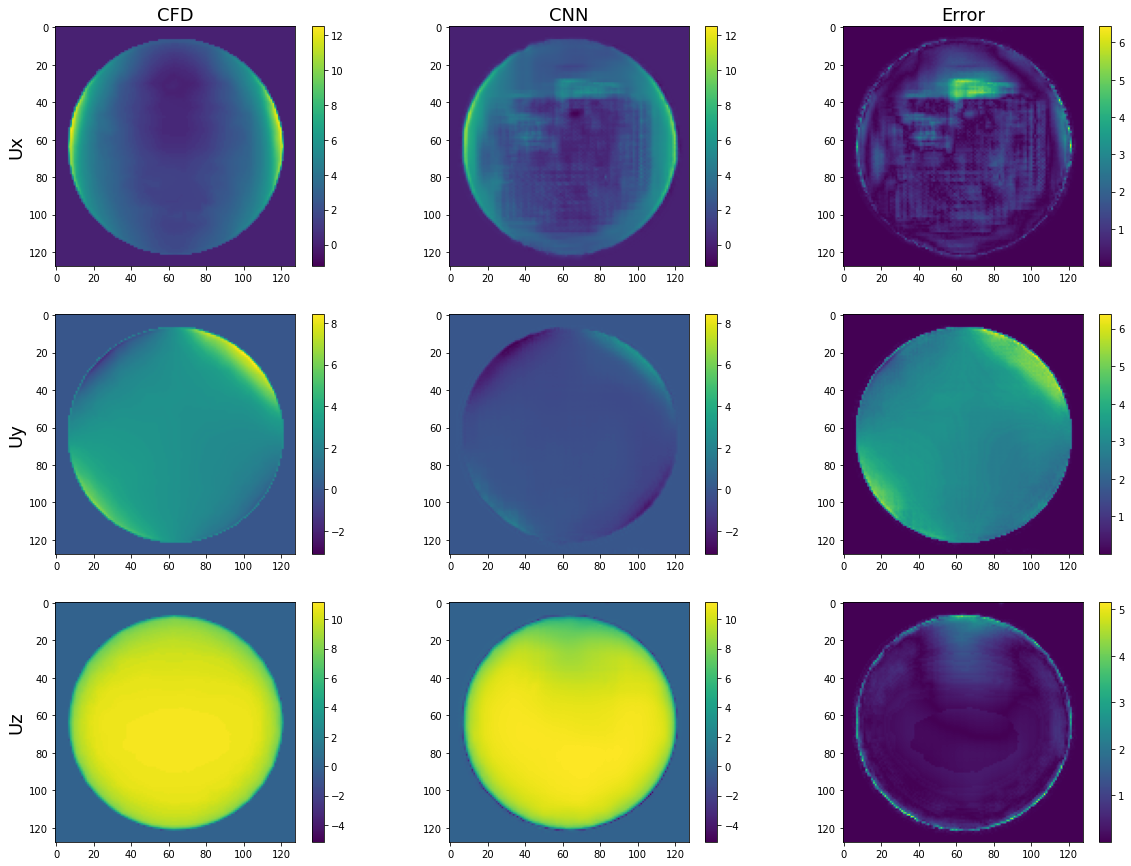

In [28]:
visualize(test_y[:10].cpu().detach().numpy(),
          out[:10].cpu().detach().numpy(),
          error[:10].cpu().detach().numpy())

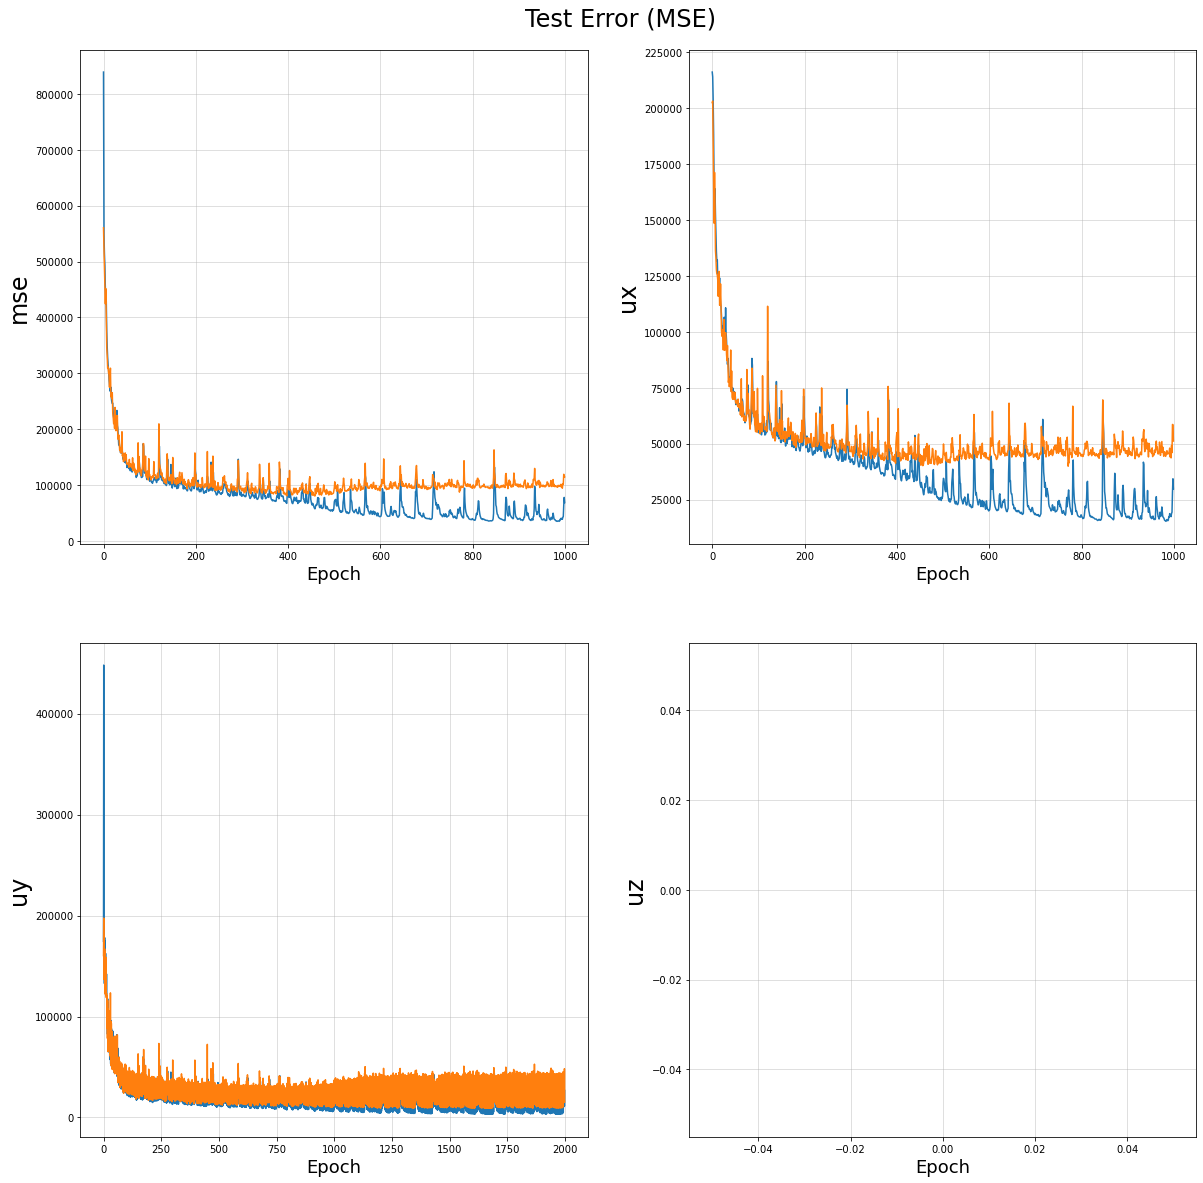

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
fig.suptitle('Test Error (MSE)', y=0.91, fontsize=24)

curve2plot = list(curves.keys())[2:]

for i in range(4):
    axs[i//2][i%2].plot(curves[curve2plot[i*2]], label='train')
    axs[i//2][i%2].plot(curves[curve2plot[i*2+1]], label='test')
    axs[i//2][i%2].grid(alpha=0.5)
#     axs[i//2][i%2].set_title(curve2plot[i*2].split('_')[1], fontsize=24)
    axs[i//2][i%2].set_ylabel(curve2plot[i*2].split('_')[1], fontsize=24)
    axs[i//2][i%2].set_xlabel('Epoch', fontsize=18)

- ошибка с выводом графика Uz исправлена, модель пересчитывается

## Model P

##### "Pressure+Velocity to Pressure"

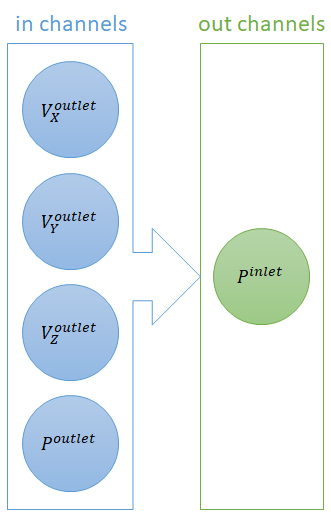

- Здесь будет та же модель только с одним выходным каналом
  - возможно стоило бы использовать finetuning, но боюсь не хватит времени чтобы разобраться как это осуществить

### Промежуточные выводы:
- За основу была взята модель (структура) из проекта DeepCFD, на данный момент, с небольшими изменениями
- В целом модель хорошо предсказывает градиенты распределения, но значительно ошибается в велечинах
- Наибольшая ошибка на границе трубы и внешней среды, что похоже на результаты из исходного проекта
- наиболее близкий к истине, как правило, оказывается предсказание для Uz (поле скоростей в направлении потока), что кажется логичным
- Однако большие неточности в предказании заначений не дают осуществить задуманную схему инференса:

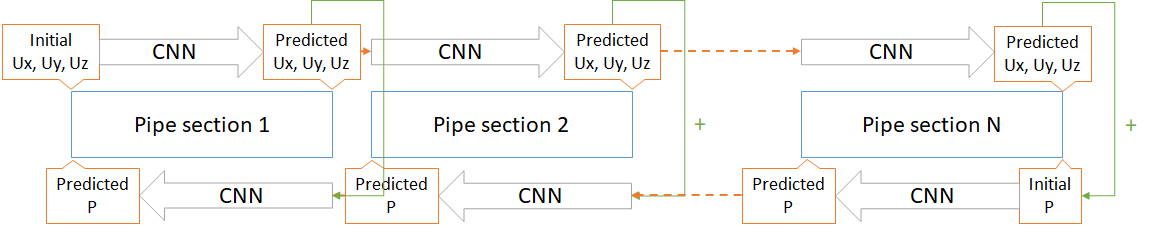

- Пока что способы решения проблемы видятся как:
  - (банальное) подбор параметров обучения
  - (банальное) попробовать другой оптимайзер
  - разобраться/заменить функцию потерь (L1-norm or L2-norm)
    - непонятно почему значения Loss такие большие, возможно где-то ошибка
  - разобраться с методом подсчета channels_weights, возможно не подходит
  - отнормировать значения в массиве geom_param
  - попробовать уменьшить количество выходных каналов